# 貸款償還預測 - 資料探索

本專案目標：預測借款人償還貸款的機率

評估指標：ROC AUC (ROC 曲線下面積)

## 1. 匯入必要的套件

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 設定視覺化樣式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 設定顯示選項
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("✓ 套件匯入完成")

✓ 套件匯入完成


## 2. 載入資料集

In [104]:
# 載入訓練集和測試集
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"訓練集大小: {train_df.shape}")
print(f"測試集大小: {test_df.shape}")
print(f"\n訓練集記憶體使用: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"測試集記憶體使用: {test_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

訓練集大小: (593994, 13)
測試集大小: (254569, 12)

訓練集記憶體使用: 223.31 MB
測試集記憶體使用: 93.76 MB

訓練集記憶體使用: 223.31 MB
測試集記憶體使用: 93.76 MB


## 3. 基本資料資訊

In [105]:
# 查看前幾筆資料
print("=" * 80)
print("訓練集前 10 筆資料:")
print("=" * 80)
display(train_df.head(10))

訓練集前 10 筆資料:


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.08,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.00
1,1,22108.02,0.17,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.00
2,2,49566.20,0.10,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.00
3,3,46858.25,0.07,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.00
4,4,25496.70,0.05,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.00
5,5,44940.30,0.06,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.00
6,6,61574.16,0.04,696,16907.71,13.52,Other,Single,High School,Self-employed,Debt consolidation,C5,1.00
7,7,45953.31,0.10,654,10111.62,12.82,Female,Married,High School,Employed,Home,D1,1.00
8,8,30592.29,0.13,713,7522.36,9.48,Male,Married,Bachelor's,Employed,Education,C5,1.00
9,9,17342.45,0.12,548,9653.48,16.04,Female,Married,Bachelor's,Self-employed,Vacation,F1,1.00


In [106]:
# 查看資料型態與缺失值
print("=" * 80)
print("訓練集資料資訊:")
print("=" * 80)
train_df.info()

print("\n" + "=" * 80)
print("缺失值統計:")
print("=" * 80)
missing_train = train_df.isnull().sum()
missing_pct = (missing_train / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    '缺失數量': missing_train,
    '缺失比例(%)': missing_pct
})
display(missing_df[missing_df['缺失數量'] > 0].sort_values('缺失數量', ascending=False))

訓練集資料資訊:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB

缺失值統計:
<class 'pandas.core.frame.Dat

,缺失數量,缺失比例(%)


In [107]:
# 特徵欄位分類
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# 移除 id 和目標變數
if 'id' in numerical_features:
    numerical_features.remove('id')
if 'loan_paid_back' in numerical_features:
    numerical_features.remove('loan_paid_back')

print("=" * 80)
print(f"數值型特徵 ({len(numerical_features)} 個):")
print("=" * 80)
for feat in numerical_features:
    print(f"  - {feat}")

print("\n" + "=" * 80)
print(f"類別型特徵 ({len(categorical_features)} 個):")
print("=" * 80)
for feat in categorical_features:
    print(f"  - {feat}")

數值型特徵 (5 個):
  - annual_income
  - debt_to_income_ratio
  - credit_score
  - loan_amount
  - interest_rate

類別型特徵 (6 個):
  - gender
  - marital_status
  - education_level
  - employment_status
  - loan_purpose
  - grade_subgrade

數值型特徵 (5 個):
  - annual_income
  - debt_to_income_ratio
  - credit_score
  - loan_amount
  - interest_rate

類別型特徵 (6 個):
  - gender
  - marital_status
  - education_level
  - employment_status
  - loan_purpose
  - grade_subgrade


## 4. 目標變數分析

目標變數 (loan_paid_back) 分布:
未償還 (0): 119,500 筆 (20.12%)
已償還 (1): 474,494 筆 (79.88%)

目標變數 (loan_paid_back) 分布:
未償還 (0): 119,500 筆 (20.12%)
已償還 (1): 474,494 筆 (79.88%)


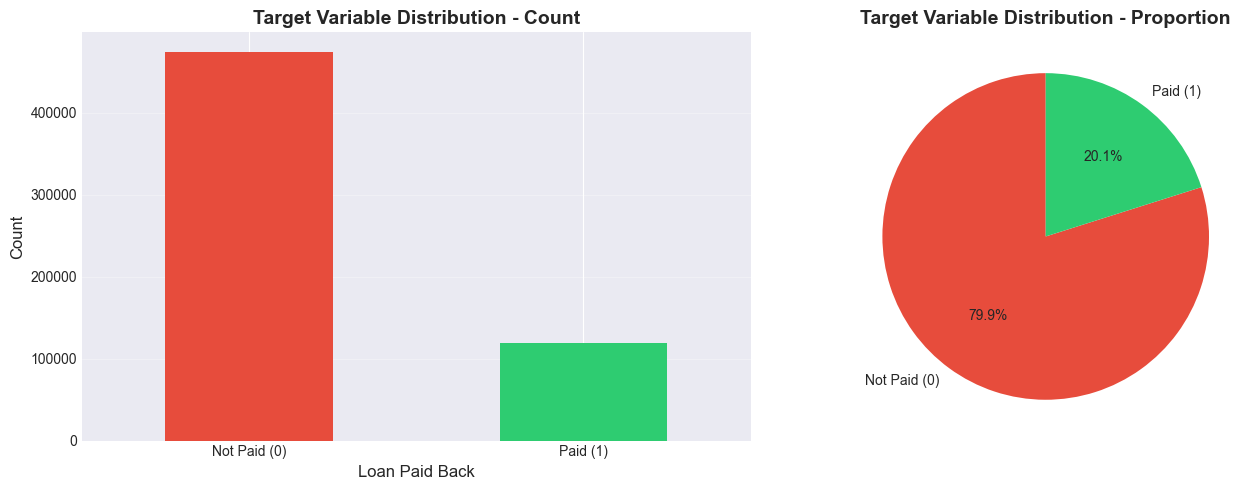

In [108]:
# 目標變數分布
if 'loan_paid_back' in train_df.columns:
    target_counts = train_df['loan_paid_back'].value_counts()
    target_pct = train_df['loan_paid_back'].value_counts(normalize=True) * 100
    
    print("=" * 80)
    print("目標變數 (loan_paid_back) 分布:")
    print("=" * 80)
    print(f"未償還 (0): {target_counts.get(0, 0):,} 筆 ({target_pct.get(0, 0):.2f}%)")
    print(f"已償還 (1): {target_counts.get(1, 0):,} 筆 ({target_pct.get(1, 0):.2f}%)")
    
    # 視覺化
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar Chart
    target_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
    axes[0].set_title('Target Variable Distribution - Count', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Loan Paid Back', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_xticklabels(['Not Paid (0)', 'Paid (1)'], rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Pie Chart
    axes[1].pie(target_counts, labels=['Not Paid (0)', 'Paid (1)'], 
                autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#2ecc71'])
    axes[1].set_title('Target Variable Distribution - Proportion', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("訓練集中找不到目標變數 'loan_paid_back'")

## 5. 數值型特徵統計摘要

In [109]:
# 數值型特徵統計摘要
print("=" * 80)
print("數值型特徵統計摘要:")
print("=" * 80)
display(train_df[numerical_features].describe().T)

數值型特徵統計摘要:


,count,mean,std,min,25%,50%,75%,max
annual_income,593994.00,48212.20,26711.94,6002.43,27934.40,46557.68,60981.32,393381.74
debt_to_income_ratio,593994.00,0.12,0.07,0.01,0.07,0.10,0.16,0.63
credit_score,593994.00,680.92,55.42,395.00,646.00,682.00,719.00,849.00
loan_amount,593994.00,15020.30,6926.53,500.09,10279.62,15000.22,18858.58,48959.95
interest_rate,593994.00,12.36,2.01,3.20,10.99,12.37,13.68,20.99


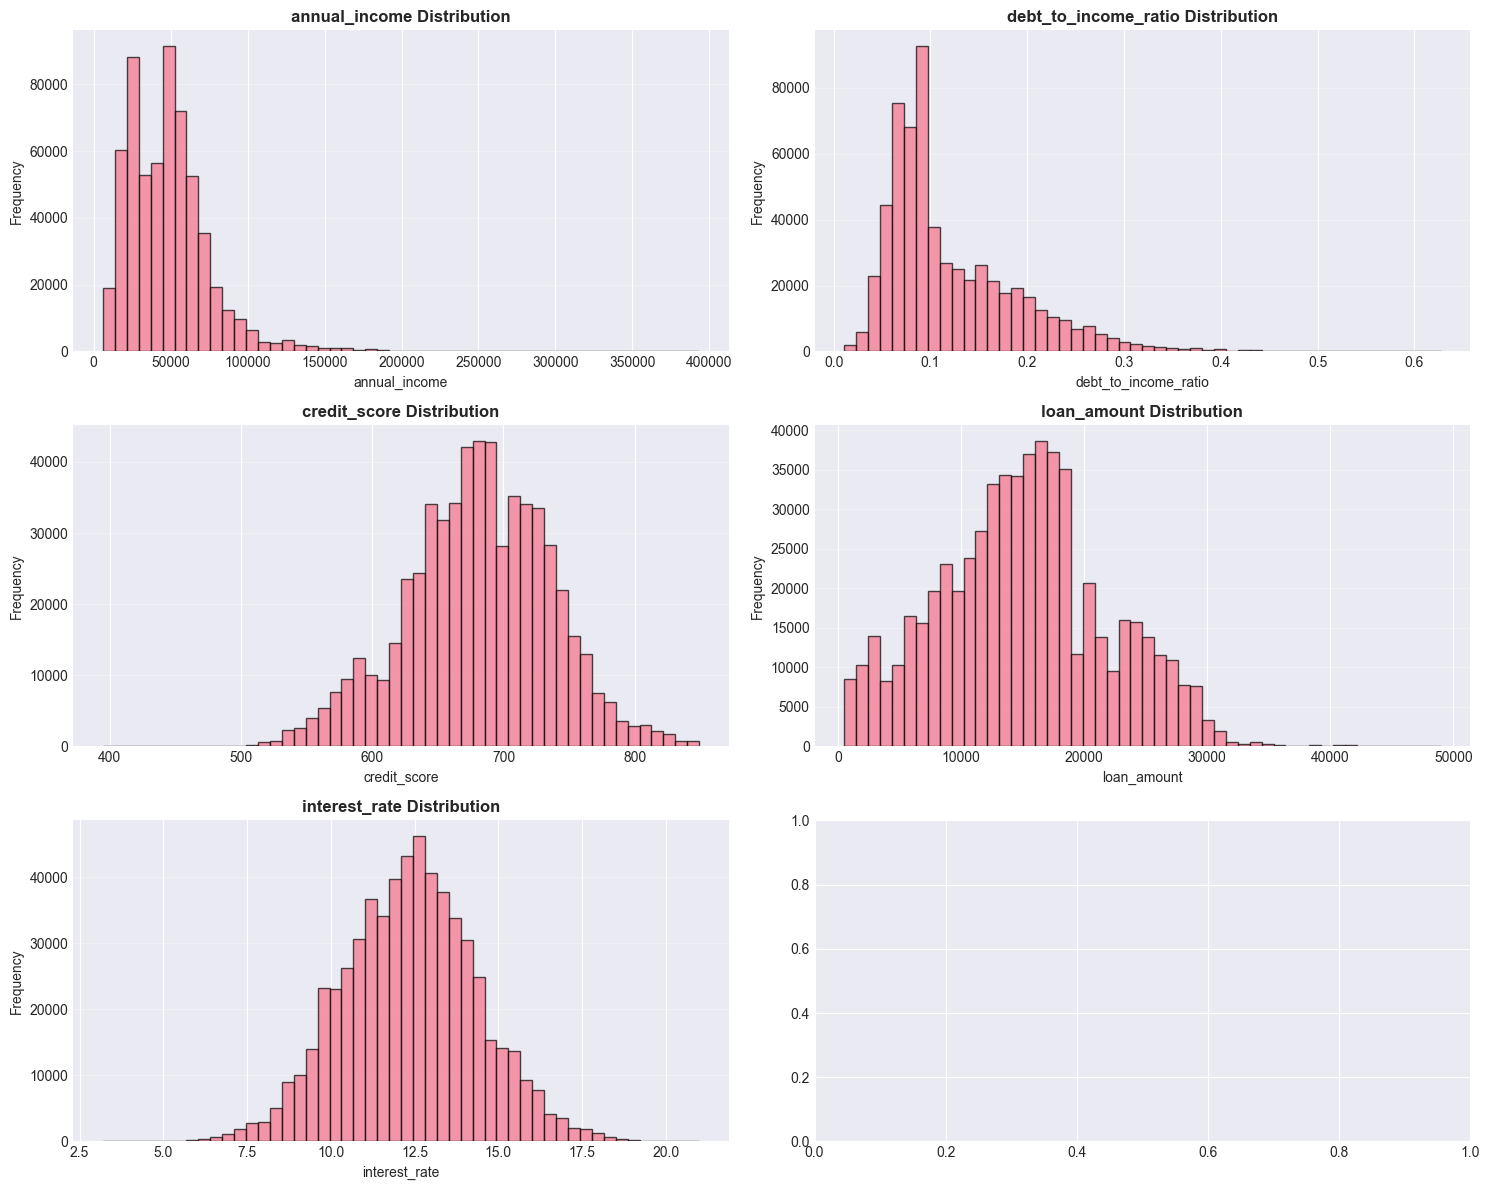

In [110]:
# 數值型特徵分布視覺化
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        axes[idx].hist(train_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 類別型特徵分析

In [111]:
# 類別型特徵唯一值統計
print("=" * 80)
print("類別型特徵唯一值統計:")
print("=" * 80)

for col in categorical_features:
    unique_count = train_df[col].nunique()
    print(f"\n{col}:")
    print(f"  唯一值數量: {unique_count}")
    print(f"  值分布:")
    value_counts = train_df[col].value_counts()
    for val, count in value_counts.items():
        pct = (count / len(train_df)) * 100
        print(f"    - {val}: {count:,} ({pct:.2f}%)")

類別型特徵唯一值統計:

gender:
  唯一值數量: 3
  值分布:
    - Female: 306,175 (51.55%)
    - Male: 284,091 (47.83%)
    - Other: 3,728 (0.63%)

marital_status:
  唯一值數量: 4
  值分布:
    - Single: 288,843 (48.63%)
    - Married: 277,239 (46.67%)
    - Divorced: 21,312 (3.59%)
    - Widowed: 6,600 (1.11%)

education_level:
  唯一值數量: 5
  值分布:
    - Bachelor's: 279,606 (47.07%)
    - High School: 183,592 (30.91%)
    - Master's: 93,097 (15.67%)
    - Other: 26,677 (4.49%)
    - PhD: 11,022 (1.86%)

employment_status:
  唯一值數量: 5
  值分布:
    - Employed: 450,645 (75.87%)
    - Unemployed: 62,485 (10.52%)
    - Self-employed: 52,480 (8.84%)
    - Retired: 16,453 (2.77%)
    - Student: 11,931 (2.01%)

loan_purpose:
  唯一值數量: 8
  值分布:
    - Debt consolidation: 324,695 (54.66%)
    - Other: 63,874 (10.75%)
    - Car: 58,108 (9.78%)
    - Home: 44,118 (7.43%)
    - Education: 36,641 (6.17%)
    - Business: 35,303 (5.94%)
    - Medical: 22,806 (3.84%)
    - Vacation: 8,449 (1.42%)

grade_subgrade:
  唯一值數量: 30
  值分布:
    -

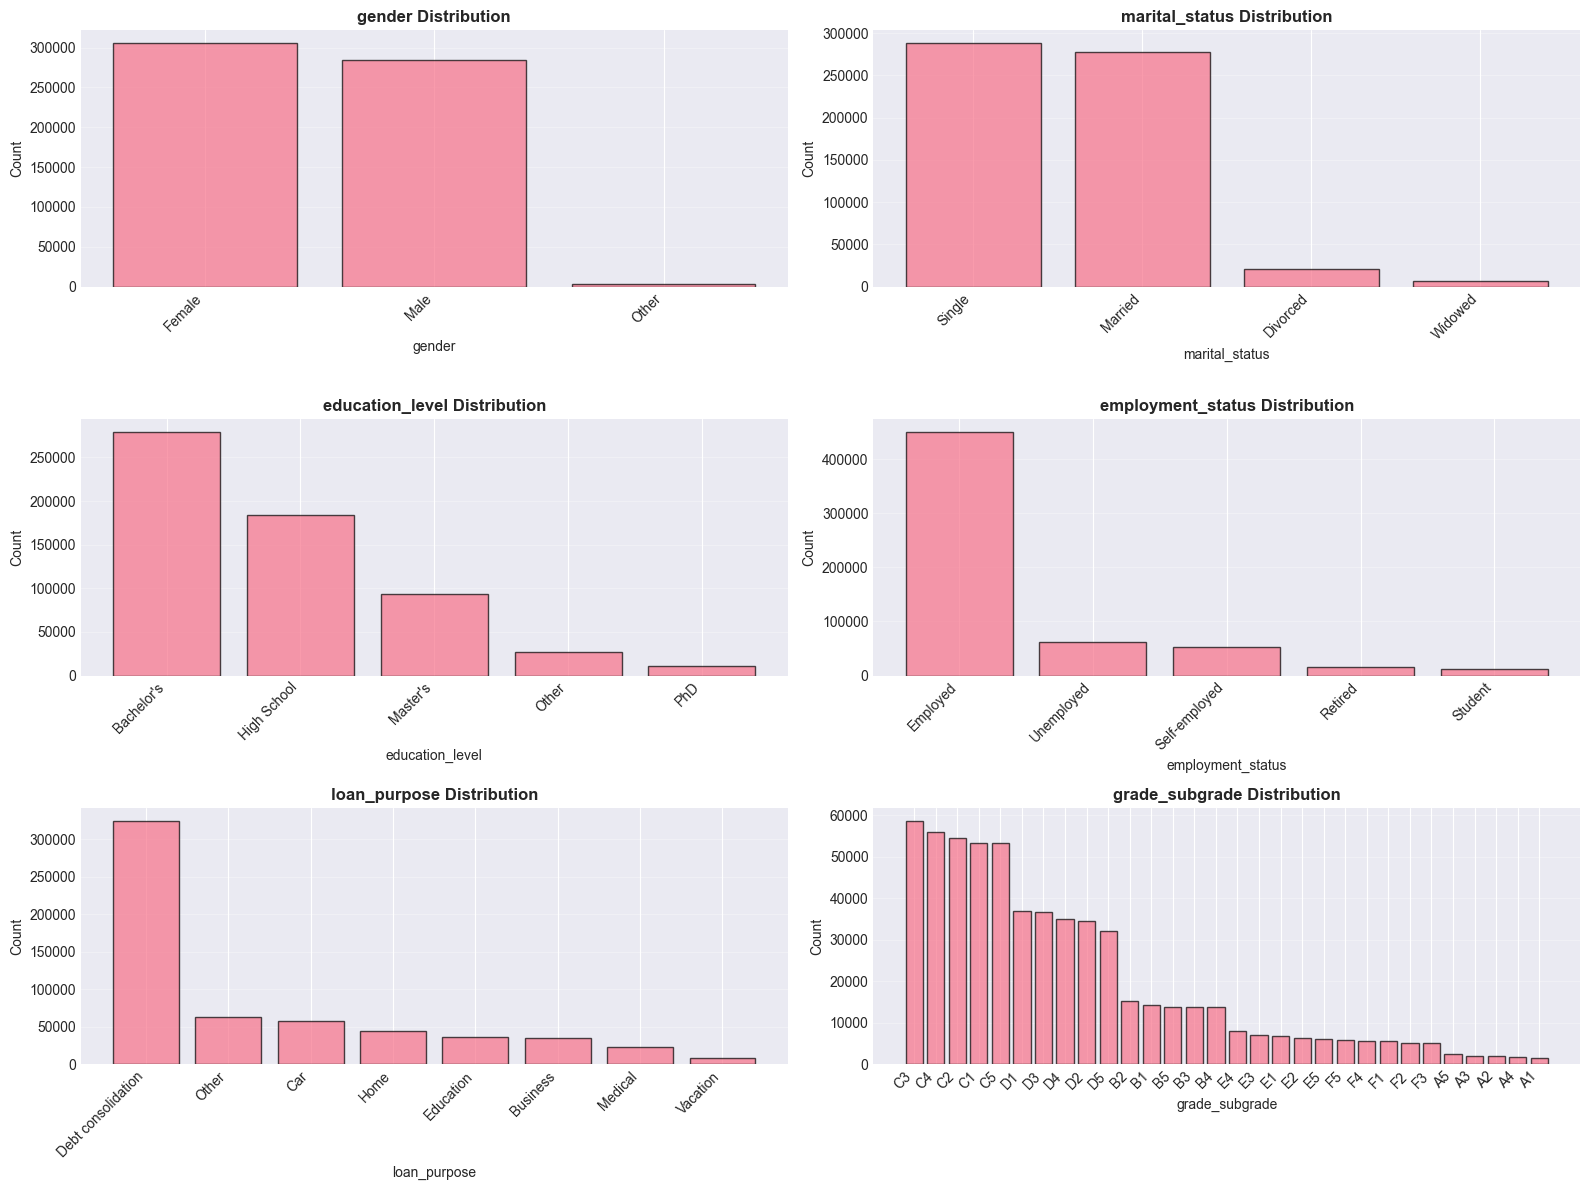

In [112]:
# 類別型特徵視覺化
n_cat_features = len(categorical_features)
if n_cat_features > 0:
    n_rows = (n_cat_features + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows * 4))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for idx, col in enumerate(categorical_features):
        value_counts = train_df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, 
                      edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(axis='y', alpha=0.3)
    
    # 隱藏多餘的子圖
    for idx in range(n_cat_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 7. 相關性分析

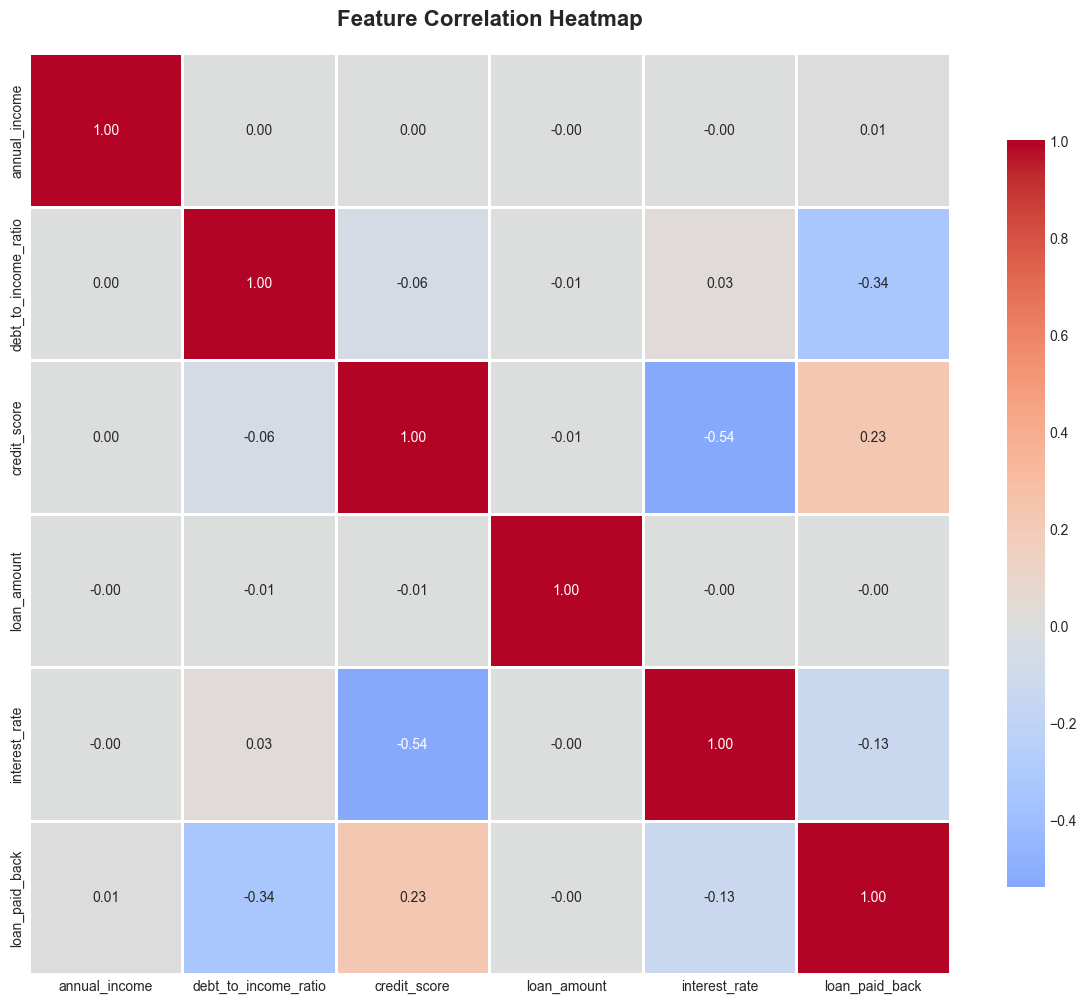


與目標變數 (loan_paid_back) 的相關性:
credit_score                  :  0.235
annual_income                 :  0.006
loan_amount                   : -0.004
interest_rate                 : -0.131
debt_to_income_ratio          : -0.336


In [113]:
# 計算數值型特徵之間的相關性
if 'loan_paid_back' in train_df.columns:
    corr_features = numerical_features + ['loan_paid_back']
else:
    corr_features = numerical_features

correlation_matrix = train_df[corr_features].corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 顯示與目標變數最相關的特徵
if 'loan_paid_back' in train_df.columns:
    print("\n" + "=" * 80)
    print("與目標變數 (loan_paid_back) 的相關性:")
    print("=" * 80)
    target_corr = correlation_matrix['loan_paid_back'].drop('loan_paid_back').sort_values(ascending=False)
    for feat, corr in target_corr.items():
        print(f"{feat:30s}: {corr:6.3f}")

## 8. 資料集摘要

In [114]:
print("=" * 80)
print("資料集摘要")
print("=" * 80)
print(f"\n📊 資料集大小:")
print(f"  - 訓練集: {train_df.shape[0]:,} 筆資料, {train_df.shape[1]} 個欄位")
print(f"  - 測試集: {test_df.shape[0]:,} 筆資料, {test_df.shape[1]} 個欄位")

print(f"\n📈 特徵類型:")
print(f"  - 數值型特徵: {len(numerical_features)} 個")
print(f"  - 類別型特徵: {len(categorical_features)} 個")

if 'loan_paid_back' in train_df.columns:
    print(f"\n🎯 目標變數:")
    print(f"  - 已償還比例: {(train_df['loan_paid_back'].sum() / len(train_df) * 100):.2f}%")
    print(f"  - 未償還比例: {((len(train_df) - train_df['loan_paid_back'].sum()) / len(train_df) * 100):.2f}%")

missing_count = train_df.isnull().sum().sum()
print(f"\n❓ 缺失值:")
print(f"  - 總缺失值: {missing_count:,}")
print(f"  - 缺失比例: {(missing_count / (train_df.shape[0] * train_df.shape[1]) * 100):.2f}%")

print("\n" + "=" * 80)

資料集摘要

📊 資料集大小:
  - 訓練集: 593,994 筆資料, 13 個欄位
  - 測試集: 254,569 筆資料, 12 個欄位

📈 特徵類型:
  - 數值型特徵: 5 個
  - 類別型特徵: 6 個

🎯 目標變數:
  - 已償還比例: 79.88%
  - 未償還比例: 20.12%

❓ 缺失值:
  - 總缺失值: 0
  - 缺失比例: 0.00%



---

## 9. Key Observations & Insights

**Distribution Analysis:**
- Most features follow relatively normal distributions without extreme outliers
- Majority of borrowers are employed (logical for loan approval)
- Education levels are mostly high school or above
- Debt consolidation is the most common loan purpose
- Loan grades show a stepwise decrease from lower to higher grades (C→B), with similar frequencies within the same grade level (e.g., C1, C2)

**Target Variable:**
- Paid back ratio: ~80% vs Not paid: ~20% (4:1 ratio - reasonably balanced, no need for SMOTE)

**Feature Importance (Correlation with target):**
- **credit_score**: 0.235 (positive correlation - higher credit score → higher repayment probability)
- **debt_to_income_ratio**: -0.336 (negative correlation - higher debt ratio → lower repayment probability)
- **interest_rate**: -0.131 (negative correlation)
- Other numerical features show weak correlations

**Strategic Insights:**
- `credit_score` and `debt_to_income_ratio` are the most influential features
- `grade_subgrade` should be important theoretically (lower grade → higher default risk)
- Potential synthetic feature: combination of high debt ratio + low credit score + low grade could severely impact repayment ability

## 10. Feature Engineering Strategy

**Encoding Plan:**

1. **Label Encoding** (ordinal features with natural ordering):
   - `education_level`: Other < High School < Bachelor's < Master's < PhD
   - `grade_subgrade`: G7 → A1 (ascending quality)

2. **One-Hot Encoding** (nominal features without natural ordering):
   - `loan_purpose`: Debt consolidation, Education, Car, Business, Vacation, Home, Other
   - `employment_status`: Employed, Unemployed

3. **Features to Drop** (low predictive value):
   - `gender`: Minimal impact on repayment ability
   - `marital_status`: Questionable significance
   - `id`: Not a feature

**Synthetic Features to Create:**
1. **risk_score**: Combined metric of debt_to_income_ratio (high), credit_score (low), and grade quality (low)
2. **income_to_loan_ratio**: annual_income / loan_amount
3. **debt_burden**: debt_to_income_ratio * loan_amount

## 11. Feature Engineering Implementation

In [115]:
# Create copies for feature engineering
train_fe = train_df.copy()
test_fe = test_df.copy()

print("Starting feature engineering...")
print(f"Original training shape: {train_fe.shape}")
print(f"Original test shape: {test_fe.shape}")

Starting feature engineering...
Original training shape: (593994, 13)
Original test shape: (254569, 12)


In [116]:
# 1. Create Synthetic Features
print("\n1. Creating synthetic features...")

# Income to loan ratio
train_fe['income_to_loan_ratio'] = train_fe['annual_income'] / (train_fe['loan_amount'] + 1)
test_fe['income_to_loan_ratio'] = test_fe['annual_income'] / (test_fe['loan_amount'] + 1)

# Debt burden
train_fe['debt_burden'] = train_fe['debt_to_income_ratio'] * train_fe['loan_amount']
test_fe['debt_burden'] = test_fe['debt_to_income_ratio'] * test_fe['loan_amount']

print("  ✓ income_to_loan_ratio created")
print("  ✓ debt_burden created")


1. Creating synthetic features...
  ✓ income_to_loan_ratio created
  ✓ debt_burden created


In [117]:
# 2. Label Encoding for Education Level
print("\n2. Label encoding education_level...")

education_mapping = {
    'Other': 0,
    'High School': 1,
    "Bachelor's": 2,
    "Master's": 3,
    'PhD': 4
}

train_fe['education_level_encoded'] = train_fe['education_level'].map(education_mapping)
test_fe['education_level_encoded'] = test_fe['education_level'].map(education_mapping)

print("  Education level mapping:")
for key, val in education_mapping.items():
    print(f"    {key}: {val}")
print("  ✓ education_level_encoded created")


2. Label encoding education_level...
  Education level mapping:
    Other: 0
    High School: 1
    Bachelor's: 2
    Master's: 3
    PhD: 4
  ✓ education_level_encoded created


In [118]:
# 3. Label Encoding for Grade Subgrade
print("\n3. Label encoding grade_subgrade...")

# Extract grade and subgrade
train_fe['grade'] = train_fe['grade_subgrade'].str[0]
train_fe['subgrade'] = train_fe['grade_subgrade'].str[1].astype(int)
test_fe['grade'] = test_fe['grade_subgrade'].str[0]
test_fe['subgrade'] = test_fe['grade_subgrade'].str[1].astype(int)

# Create numerical encoding: G7=0, G6=1, ..., A1=34
grade_mapping = {'G': 0, 'F': 5, 'E': 10, 'D': 15, 'C': 20, 'B': 25, 'A': 30}
train_fe['grade_numeric'] = train_fe['grade'].map(grade_mapping) + (5 - train_fe['subgrade'])
test_fe['grade_numeric'] = test_fe['grade'].map(grade_mapping) + (5 - test_fe['subgrade'])

print("  Grade mapping (higher is better):")
print("    G1-G7: 0-4, F1-F5: 5-9, E1-E5: 10-14, D1-D5: 15-19")
print("    C1-C5: 20-24, B1-B5: 25-29, A1-A5: 30-34")
print("  ✓ grade_numeric created")


3. Label encoding grade_subgrade...
  Grade mapping (higher is better):
    G1-G7: 0-4, F1-F5: 5-9, E1-E5: 10-14, D1-D5: 15-19
    C1-C5: 20-24, B1-B5: 25-29, A1-A5: 30-34
  ✓ grade_numeric created
  Grade mapping (higher is better):
    G1-G7: 0-4, F1-F5: 5-9, E1-E5: 10-14, D1-D5: 15-19
    C1-C5: 20-24, B1-B5: 25-29, A1-A5: 30-34
  ✓ grade_numeric created


In [119]:
# 4. Create Risk Score (synthetic feature combining key risk factors)
print("\n4. Creating composite risk_score...")

# Normalize features to 0-1 range for combining
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_fe['credit_score_norm'] = scaler.fit_transform(train_fe[['credit_score']])
test_fe['credit_score_norm'] = scaler.transform(test_fe[['credit_score']])

train_fe['debt_ratio_norm'] = scaler.fit_transform(train_fe[['debt_to_income_ratio']])
test_fe['debt_ratio_norm'] = scaler.transform(test_fe[['debt_to_income_ratio']])

train_fe['grade_norm'] = scaler.fit_transform(train_fe[['grade_numeric']])
test_fe['grade_norm'] = scaler.transform(test_fe[['grade_numeric']])

# Risk score: higher debt + lower credit + lower grade = higher risk (lower repayment probability)
train_fe['risk_score'] = (
    train_fe['debt_ratio_norm'] * 0.4 +           # 40% weight on debt ratio
    (1 - train_fe['credit_score_norm']) * 0.35 +  # 35% weight on credit score (inverted)
    (1 - train_fe['grade_norm']) * 0.25           # 25% weight on grade (inverted)
)

test_fe['risk_score'] = (
    test_fe['debt_ratio_norm'] * 0.4 +
    (1 - test_fe['credit_score_norm']) * 0.35 +
    (1 - test_fe['grade_norm']) * 0.25
)

print("  ✓ risk_score created (weighted combination of debt_ratio, credit_score, grade)")
print("    Weights: debt_ratio=40%, credit_score=35%, grade=25%")


4. Creating composite risk_score...
  ✓ risk_score created (weighted combination of debt_ratio, credit_score, grade)
    Weights: debt_ratio=40%, credit_score=35%, grade=25%


In [120]:
# 5. One-Hot Encoding for Categorical Features
print("\n5. One-hot encoding categorical features...")

# Features to one-hot encode
ohe_features = ['loan_purpose', 'employment_status']

for df_name, df in [('train', train_fe), ('test', test_fe)]:
    for feature in ohe_features:
        dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
        if df_name == 'train':
            train_fe = pd.concat([train_fe, dummies], axis=1)
        else:
            test_fe = pd.concat([test_fe, dummies], axis=1)
        print(f"  ✓ {feature} encoded ({dummies.shape[1]} new columns)")

print("\n6. Dropping unnecessary columns...")
# Drop original categorical columns and low-value features
drop_cols = ['id', 'gender', 'marital_status', 'education_level', 'grade_subgrade', 
             'loan_purpose', 'employment_status', 'grade', 'subgrade',
             'credit_score_norm', 'debt_ratio_norm', 'grade_norm']

# Remove target from training features
if 'loan_paid_back' in train_fe.columns:
    y_train = train_fe['loan_paid_back']
    drop_cols.append('loan_paid_back')

train_fe = train_fe.drop(columns=drop_cols, errors='ignore')
test_fe = test_fe.drop(columns=drop_cols, errors='ignore')

print(f"  ✓ Dropped {len(drop_cols)} columns")
print(f"\nFinal feature engineering results:")
print(f"  Training shape: {train_fe.shape}")
print(f"  Test shape: {test_fe.shape}")
print(f"  Target variable shape: {y_train.shape}")


5. One-hot encoding categorical features...
  ✓ loan_purpose encoded (7 new columns)
  ✓ employment_status encoded (4 new columns)
  ✓ loan_purpose encoded (7 new columns)
  ✓ loan_purpose encoded (7 new columns)
  ✓ employment_status encoded (4 new columns)

6. Dropping unnecessary columns...
  ✓ Dropped 13 columns

Final feature engineering results:
  Training shape: (593994, 21)
  Test shape: (254569, 21)
  Target variable shape: (593994,)
  ✓ employment_status encoded (4 new columns)

6. Dropping unnecessary columns...
  ✓ Dropped 13 columns

Final feature engineering results:
  Training shape: (593994, 21)
  Test shape: (254569, 21)
  Target variable shape: (593994,)


In [121]:
# Display final feature list
print("\n" + "=" * 80)
print("Final Feature List:")
print("=" * 80)
for i, col in enumerate(train_fe.columns, 1):
    print(f"{i:2d}. {col}")
print("=" * 80)


Final Feature List:
 1. annual_income
 2. debt_to_income_ratio
 3. credit_score
 4. loan_amount
 5. interest_rate
 6. income_to_loan_ratio
 7. debt_burden
 8. education_level_encoded
 9. grade_numeric
10. risk_score
11. loan_purpose_Car
12. loan_purpose_Debt consolidation
13. loan_purpose_Education
14. loan_purpose_Home
15. loan_purpose_Medical
16. loan_purpose_Other
17. loan_purpose_Vacation
18. employment_status_Retired
19. employment_status_Self-employed
20. employment_status_Student
21. employment_status_Unemployed


## 12. Model Training & Evaluation

**Models to Train:**
1. **LightGBM** - Fast, efficient gradient boosting (typically best for tabular data)
2. **XGBoost** - Robust gradient boosting with regularization
3. **Random Forest** - Ensemble method, good baseline
4. **Logistic Regression** - Simple baseline for comparison

**Evaluation Metric:** ROC AUC Score

In [122]:
# Train-validation split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_train, X_val, y_train_split, y_val = train_test_split(
    train_fe, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Data split completed:")
print(f"  Training set: {X_train.shape}")
print(f"  Validation set: {X_val.shape}")
print(f"\nTarget distribution in training set:")
print(f"  Paid back (1): {(y_train_split.sum() / len(y_train_split) * 100):.2f}%")
print(f"  Not paid (0): {((len(y_train_split) - y_train_split.sum()) / len(y_train_split) * 100):.2f}%")

Data split completed:
  Training set: (475195, 21)
  Validation set: (118799, 21)

Target distribution in training set:
  Paid back (1): 79.88%
  Not paid (0): 20.12%


### 12.1 Baseline: Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for Logistic Regression
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_val_scaled = scaler_lr.transform(X_val)

# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train_split)

# Predictions
y_pred_lr = lr_model.predict_proba(X_val_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_val, y_pred_lr)

print(f"\n{'='*80}")
print(f"Logistic Regression Results:")
print(f"{'='*80}")
print(f"ROC AUC Score: {roc_auc_lr:.6f}")
print(f"{'='*80}")

Training Logistic Regression...


d:\Kaggle\loan_payback_predict\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Logistic Regression Results:
ROC AUC Score: 0.909955


### 12.2 Random Forest

In [124]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_model.fit(X_train, y_train_split)

# Predictions
y_pred_rf = rf_model.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_pred_rf)

print(f"\n{'='*80}")
print(f"Random Forest Results:")
print(f"{'='*80}")
print(f"ROC AUC Score: {roc_auc_rf:.6f}")
print(f"{'='*80}")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   26.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   26.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



Random Forest Results:
ROC AUC Score: 0.913868


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.2s finished


### 12.3 LightGBM

In [125]:
import lightgbm as lgb

print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train_split,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Predictions
y_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]
roc_auc_lgb = roc_auc_score(y_val, y_pred_lgb)

print(f"\n{'='*80}")
print(f"LightGBM Results:")
print(f"{'='*80}")
print(f"ROC AUC Score: {roc_auc_lgb:.6f}")
print(f"Best iteration: {lgb_model.best_iteration_}")
print(f"{'='*80}")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.917391
[100]	valid_0's auc: 0.917391
[200]	valid_0's auc: 0.919805
[200]	valid_0's auc: 0.919805
[300]	valid_0's auc: 0.920354
[300]	valid_0's auc: 0.920354
[400]	valid_0's auc: 0.920911
[400]	valid_0's auc: 0.920911
[500]	valid_0's auc: 0.921138
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.921138
[500]	valid_0's auc: 0.921138
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.921138

LightGBM Results:
ROC AUC Score: 0.921138
Best iteration: 499

LightGBM Results:
ROC AUC Score: 0.921138
Best iteration: 499


### 12.4 XGBoost

In [126]:
import xgboost as xgb

print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.05,
    n_estimators=500,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

xgb_model.fit(
    X_train, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# Predictions
y_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb)

print(f"\n{'='*80}")
print(f"XGBoost Results:")
print(f"{'='*80}")
print(f"ROC AUC Score: {roc_auc_xgb:.6f}")
print(f"{'='*80}")

Training XGBoost...
[0]	validation_0-auc:0.90634
[0]	validation_0-auc:0.90634
[100]	validation_0-auc:0.91575
[100]	validation_0-auc:0.91575
[200]	validation_0-auc:0.91758
[200]	validation_0-auc:0.91758
[300]	validation_0-auc:0.91874
[300]	validation_0-auc:0.91874
[400]	validation_0-auc:0.91952
[400]	validation_0-auc:0.91952
[499]	validation_0-auc:0.91994
[499]	validation_0-auc:0.91994

XGBoost Results:
ROC AUC Score: 0.919940

XGBoost Results:
ROC AUC Score: 0.919940


### 12.5 Model Comparison


MODEL COMPARISON - VALIDATION SET


,Model,ROC AUC Score
2,LightGBM,0.92
3,XGBoost,0.92
1,Random Forest,0.91
0,Logistic Regression,0.91


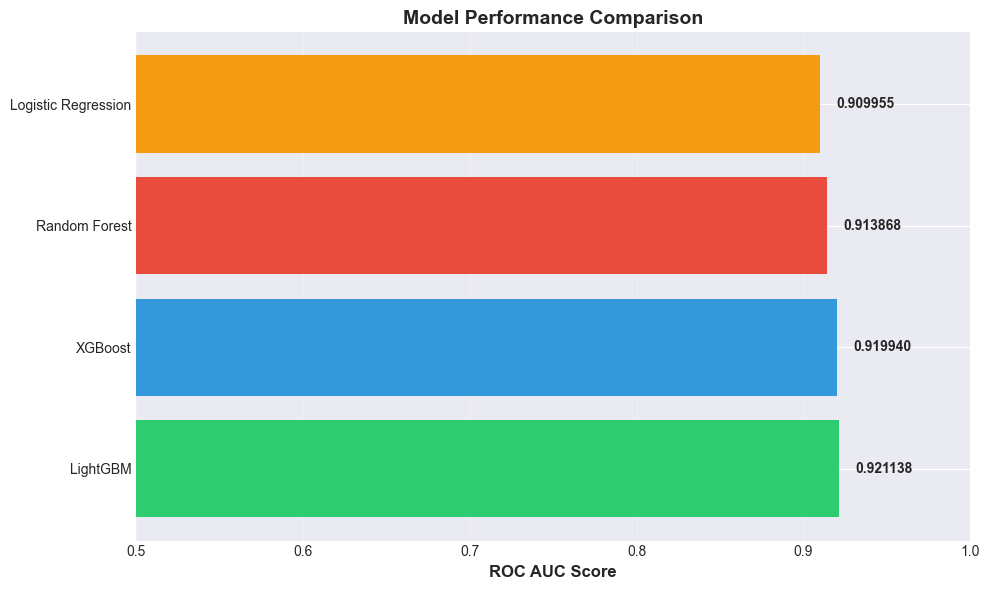


Best Model: LightGBM with ROC AUC = 0.921138


In [127]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost'],
    'ROC AUC Score': [roc_auc_lr, roc_auc_rf, roc_auc_lgb, roc_auc_xgb]
}).sort_values('ROC AUC Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET")
print("="*80)
display(results)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(results['Model'], results['ROC AUC Score'], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
ax.set_xlabel('ROC AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0.5, 1.0])
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (model, score) in enumerate(zip(results['Model'], results['ROC AUC Score'])):
    ax.text(score + 0.01, i, f'{score:.6f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nBest Model: {results.iloc[0]['Model']} with ROC AUC = {results.iloc[0]['ROC AUC Score']:.6f}")

## 13. Grade Subgrade Analysis - Is the encoding too granular?

In [128]:
# Analyze repayment rate by grade and subgrade
print("="*80)
print("Repayment Rate Analysis by Loan Grade")
print("="*80)

# Extract grade from train_df
train_df['grade'] = train_df['grade_subgrade'].str[0]

# By main grade only (A, B, C, D, E, F, G)
grade_repayment = train_df.groupby('grade')['loan_paid_back'].agg(['mean', 'count'])
grade_repayment.columns = ['Repayment_Rate', 'Count']
grade_repayment = grade_repayment.sort_index(ascending=False)

print("\n1. By Main Grade (A-G):")
display(grade_repayment)

Repayment Rate Analysis by Loan Grade

1. By Main Grade (A-G):

1. By Main Grade (A-G):


,Repayment_Rate,Count
grade,,
F,0.63,27301
E,0.65,34458
D,0.72,175353
C,0.85,275775
B,0.93,71251
A,0.95,9856


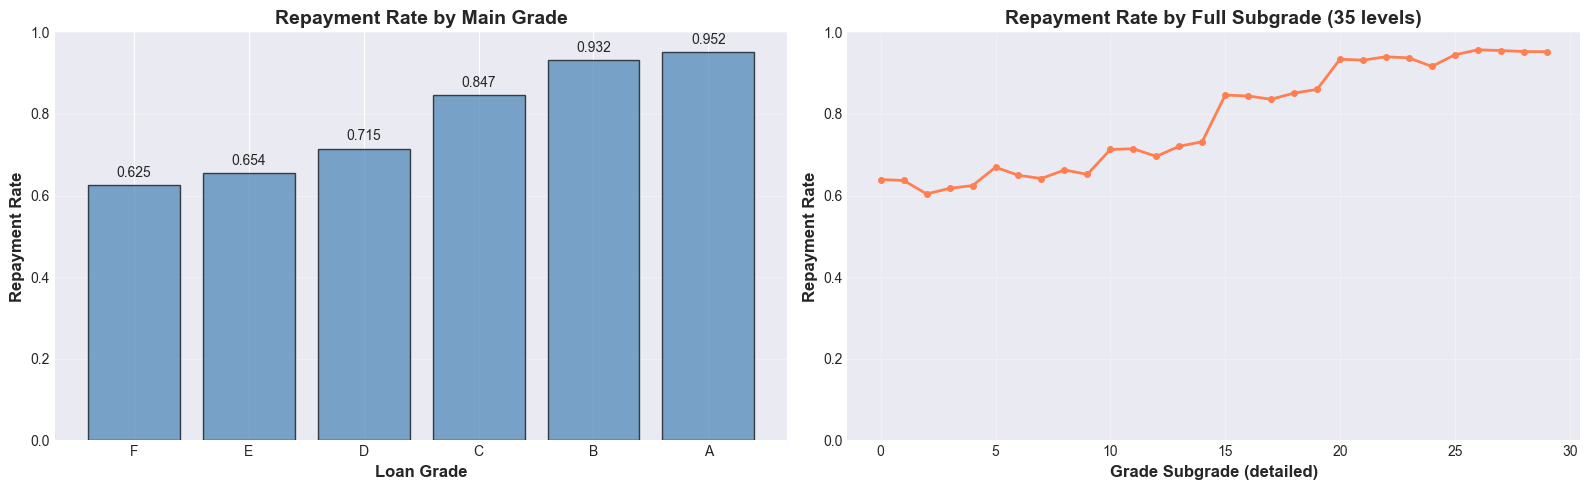

In [129]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Repayment rate by main grade
axes[0].bar(grade_repayment.index, grade_repayment['Repayment_Rate'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Loan Grade', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Repayment Rate', fontsize=12, fontweight='bold')
axes[0].set_title('Repayment Rate by Main Grade', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Add value labels
for i, (idx, val) in enumerate(zip(grade_repayment.index, grade_repayment['Repayment_Rate'])):
    axes[0].text(i, val + 0.02, f'{val:.3f}', ha='center', fontsize=10)

# Plot 2: Repayment rate by full subgrade
subgrade_repayment = train_df.groupby('grade_subgrade')['loan_paid_back'].mean().sort_index(ascending=False)
axes[1].plot(range(len(subgrade_repayment)), subgrade_repayment.values, 
             marker='o', linewidth=2, markersize=4, color='coral')
axes[1].set_xlabel('Grade Subgrade (detailed)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Repayment Rate', fontsize=12, fontweight='bold')
axes[1].set_title('Repayment Rate by Full Subgrade (35 levels)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

In [130]:
# Check if relationship is linear
# Add grade_numeric to train_df if not already there
grade_mapping = {'G': 0, 'F': 5, 'E': 10, 'D': 15, 'C': 20, 'B': 25, 'A': 30}
train_df['subgrade'] = train_df['grade_subgrade'].str[1].astype(int)
train_df['grade_numeric'] = train_df['grade'].map(grade_mapping) + (5 - train_df['subgrade'])

print("\n2. Correlation Analysis:")
corr_detailed = train_df['grade_numeric'].corr(train_df['loan_paid_back'])
print(f"Correlation between grade_numeric (0-34, detailed) and loan_paid_back: {corr_detailed:.4f}")

# Compare: Use only main grade (7 levels) vs full subgrade (35 levels)
print("\n3. Test simpler encoding:")
simple_grade_mapping = {'G': 0, 'F': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6}
train_df['grade_simple'] = train_df['grade'].map(simple_grade_mapping)
corr_simple = train_df['grade_simple'].corr(train_df['loan_paid_back'])
print(f"Correlation with simple grade (7 levels): {corr_simple:.4f}")

print("\n4. Analysis Summary:")
print(f"  Detailed encoding (35 levels) correlation: {corr_detailed:.4f}")
print(f"  Simple encoding (7 levels) correlation:   {corr_simple:.4f}")
print(f"  Difference: {abs(corr_detailed - corr_simple):.4f}")

if abs(corr_detailed - corr_simple) < 0.01:
    print("\n  💡 Insight: Simple 7-level encoding captures nearly the same information!")
    print("     Consider using simpler encoding to reduce model complexity.")
else:
    print("\n  💡 Insight: Detailed 35-level encoding provides additional predictive value.")
    print("     Keep the detailed encoding for better performance.")


2. Correlation Analysis:
Correlation between grade_numeric (0-34, detailed) and loan_paid_back: 0.2124

3. Test simpler encoding:
Correlation with simple grade (7 levels): 0.2188

4. Analysis Summary:
  Detailed encoding (35 levels) correlation: 0.2124
  Simple encoding (7 levels) correlation:   0.2188
  Difference: 0.0064

  💡 Insight: Simple 7-level encoding captures nearly the same information!
     Consider using simpler encoding to reduce model complexity.


## 14. Model Ensemble - Combining predictions for better performance

In [131]:
print("="*80)
print("MODEL ENSEMBLE STRATEGIES")
print("="*80)

# Strategy 1: Simple Averaging
print("\n1. Simple Average (equal weights):")
y_pred_ensemble_avg = (y_pred_lr + y_pred_rf + y_pred_lgb + y_pred_xgb) / 4
roc_auc_ensemble_avg = roc_auc_score(y_val, y_pred_ensemble_avg)
print(f"   ROC AUC: {roc_auc_ensemble_avg:.6f}")

# Strategy 2: Weighted Average (based on individual performance)
print("\n2. Weighted Average (based on validation performance):")
total_score = roc_auc_lr + roc_auc_rf + roc_auc_lgb + roc_auc_xgb
w_lr = roc_auc_lr / total_score
w_rf = roc_auc_rf / total_score
w_lgb = roc_auc_lgb / total_score
w_xgb = roc_auc_xgb / total_score

print(f"   Weights: LR={w_lr:.3f}, RF={w_rf:.3f}, LGB={w_lgb:.3f}, XGB={w_xgb:.3f}")
y_pred_ensemble_weighted = (w_lr * y_pred_lr + w_rf * y_pred_rf + 
                             w_lgb * y_pred_lgb + w_xgb * y_pred_xgb)
roc_auc_ensemble_weighted = roc_auc_score(y_val, y_pred_ensemble_weighted)
print(f"   ROC AUC: {roc_auc_ensemble_weighted:.6f}")

# Strategy 3: Only top 2 models (usually LGB + XGB)
print("\n3. Top 2 Models Average (LightGBM + XGBoost):")
y_pred_ensemble_top2 = (y_pred_lgb + y_pred_xgb) / 2
roc_auc_ensemble_top2 = roc_auc_score(y_val, y_pred_ensemble_top2)
print(f"   ROC AUC: {roc_auc_ensemble_top2:.6f}")

# Strategy 4: Rank averaging (more robust to outliers)
print("\n4. Rank Average:")
from scipy.stats import rankdata
rank_lr = rankdata(y_pred_lr) / len(y_pred_lr)
rank_rf = rankdata(y_pred_rf) / len(y_pred_rf)
rank_lgb = rankdata(y_pred_lgb) / len(y_pred_lgb)
rank_xgb = rankdata(y_pred_xgb) / len(y_pred_xgb)

y_pred_ensemble_rank = (rank_lr + rank_rf + rank_lgb + rank_xgb) / 4
roc_auc_ensemble_rank = roc_auc_score(y_val, y_pred_ensemble_rank)
print(f"   ROC AUC: {roc_auc_ensemble_rank:.6f}")

MODEL ENSEMBLE STRATEGIES

1. Simple Average (equal weights):
   ROC AUC: 0.918280

2. Weighted Average (based on validation performance):
   Weights: LR=0.248, RF=0.249, LGB=0.251, XGB=0.251
   ROC AUC: 0.918299

3. Top 2 Models Average (LightGBM + XGBoost):
   ROC AUC: 0.920856

4. Rank Average:
   ROC AUC: 0.918328


In [132]:
# Compare all ensemble methods
ensemble_results = pd.DataFrame({
    'Method': ['Simple Average', 'Weighted Average', 'Top 2 Average (LGB+XGB)', 
               'Rank Average', 'Best Single Model (LGB)'],
    'ROC AUC Score': [roc_auc_ensemble_avg, roc_auc_ensemble_weighted, 
                       roc_auc_ensemble_top2, roc_auc_ensemble_rank, roc_auc_lgb]
}).sort_values('ROC AUC Score', ascending=False)

print("\n" + "="*80)
print("ENSEMBLE COMPARISON")
print("="*80)
display(ensemble_results)

best_ensemble_method = ensemble_results.iloc[0]['Method']
best_ensemble_score = ensemble_results.iloc[0]['ROC AUC Score']
improvement = best_ensemble_score - roc_auc_lgb

print(f"\n✅ Best Method: {best_ensemble_method}")
print(f"   Score: {best_ensemble_score:.6f}")
print(f"   Improvement over single LGB: {improvement:+.6f} ({improvement*100:+.3f}%)")
print("="*80)


ENSEMBLE COMPARISON


,Method,ROC AUC Score
4,Best Single Model (LGB),0.92
2,Top 2 Average (LGB+XGB),0.92
3,Rank Average,0.92
1,Weighted Average,0.92
0,Simple Average,0.92



✅ Best Method: Best Single Model (LGB)
   Score: 0.921138
   Improvement over single LGB: +0.000000 (+0.000%)


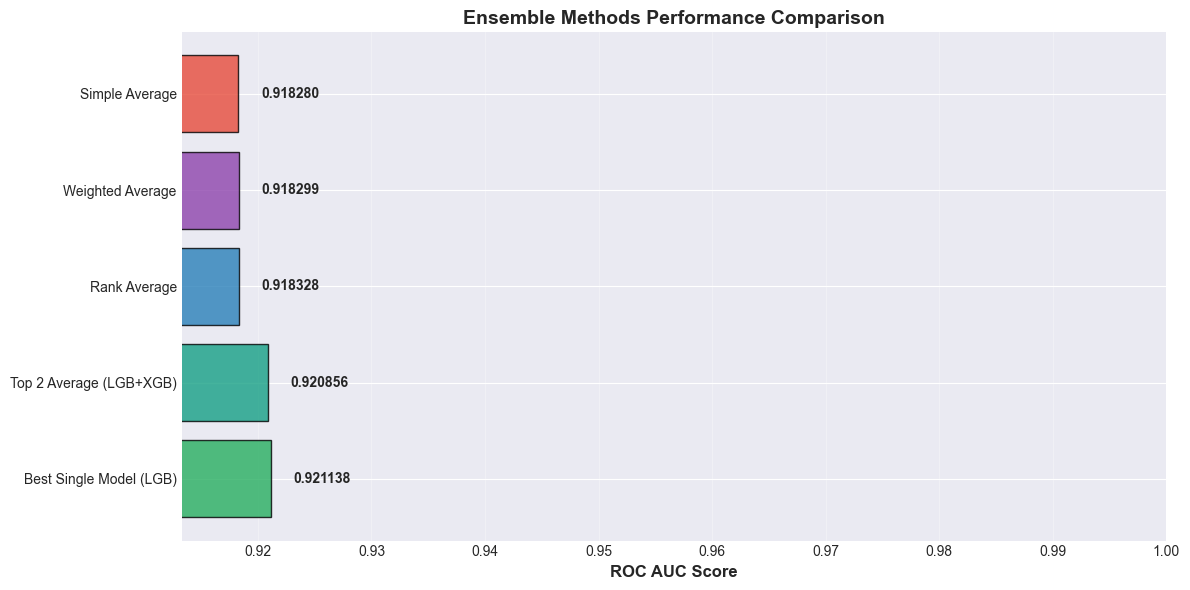

In [133]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#27ae60', '#16a085', '#2980b9', '#8e44ad', '#e74c3c']
bars = ax.barh(ensemble_results['Method'], ensemble_results['ROC AUC Score'], 
               color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('ROC AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Ensemble Methods Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([min(ensemble_results['ROC AUC Score']) - 0.005, 1.0])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, score in enumerate(ensemble_results['ROC AUC Score']):
    ax.text(score + 0.002, i, f'{score:.6f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 15. Generate Final Submission with Best Ensemble Method

In [134]:
print("="*80)
print("GENERATING FINAL SUBMISSION WITH ENSEMBLE")
print("="*80)

# Get predictions from all models on test set
test_pred_lr = lr_model.predict_proba(scaler_lr.transform(test_fe))[:, 1]
test_pred_rf = rf_model.predict_proba(test_fe)[:, 1]
test_pred_lgb = lgb_model.predict_proba(test_fe)[:, 1]
test_pred_xgb = xgb_model.predict_proba(test_fe)[:, 1]

# Apply the best ensemble method based on validation results
# You can change this based on which method performed best above

# Option 1: Top 2 Average (LightGBM + XGBoost) - Usually works well
test_predictions_top2 = (test_pred_lgb + test_pred_xgb) / 2

# Option 2: Weighted Average
test_predictions_weighted = (w_lgb * test_pred_lgb + w_xgb * test_pred_xgb + 
                              w_rf * test_pred_rf + w_lr * test_pred_lr)

# Option 3: Simple Average of all 4
test_predictions_simple = (test_pred_lr + test_pred_rf + test_pred_lgb + test_pred_xgb) / 4

# Option 4: Rank Average
from scipy.stats import rankdata
rank_lr_test = rankdata(test_pred_lr) / len(test_pred_lr)
rank_rf_test = rankdata(test_pred_rf) / len(test_pred_rf)
rank_lgb_test = rankdata(test_pred_lgb) / len(test_pred_lgb)
rank_xgb_test = rankdata(test_pred_xgb) / len(test_pred_xgb)
test_predictions_rank = (rank_lr_test + rank_rf_test + rank_lgb_test + rank_xgb_test) / 4

# Choose the best method based on validation results
# Default to Top 2 Average if unsure
if best_ensemble_method == 'Top 2 Average (LGB+XGB)':
    final_predictions = test_predictions_top2
    method_used = "Top 2 Average (LGB+XGB)"
elif best_ensemble_method == 'Weighted Average':
    final_predictions = test_predictions_weighted
    method_used = "Weighted Average"
elif best_ensemble_method == 'Rank Average':
    final_predictions = test_predictions_rank
    method_used = "Rank Average"
elif best_ensemble_method == 'Simple Average':
    final_predictions = test_predictions_simple
    method_used = "Simple Average"
else:
    # Use single best model (LGB)
    final_predictions = test_pred_lgb
    method_used = "Single LightGBM"

print(f"\n✅ Using method: {method_used}")
print(f"   Expected validation ROC AUC: {best_ensemble_score:.6f}")

GENERATING FINAL SUBMISSION WITH ENSEMBLE


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.6s finished



✅ Using method: Single LightGBM
   Expected validation ROC AUC: 0.921138


In [135]:
# Create submission
submission_ensemble = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back': final_predictions
})

# Save submission file
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print(f"\n{'='*80}")
print("SUBMISSION FILE GENERATED")
print(f"{'='*80}")
print(f"File: submission_ensemble.csv")
print(f"Shape: {submission_ensemble.shape}")
print(f"\nFirst 10 predictions:")
display(submission_ensemble.head(10))
print(f"\nPrediction statistics:")
print(f"  Mean probability: {final_predictions.mean():.4f}")
print(f"  Std:  {final_predictions.std():.4f}")
print(f"  Min:  {final_predictions.min():.4f}")
print(f"  Max:  {final_predictions.max():.4f}")
print(f"{'='*80}")
print(f"\n🎯 Expected improvement from ensemble: {improvement:+.6f}")
print(f"   If validation ROC AUC was 0.92241, new score could be ~{0.92241 + improvement:.5f}")


SUBMISSION FILE GENERATED
File: submission_ensemble.csv
Shape: (254569, 2)

First 10 predictions:


,id,loan_paid_back
0,593994,0.93
1,593995,0.98
2,593996,0.45
3,593997,0.93
4,593998,0.97
5,593999,0.98
6,594000,0.98
7,594001,0.96
8,594002,0.94
9,594003,0.01



Prediction statistics:
  Mean probability: 0.7997
  Std:  0.2956
  Min:  0.0005
  Max:  0.9997

🎯 Expected improvement from ensemble: +0.000000
   If validation ROC AUC was 0.92241, new score could be ~0.92241


## 13. Generate Submission File

In [136]:
# Use the best performing model to generate predictions on test set
# Assuming LightGBM or XGBoost will likely be the best

# Get test predictions from the best model (you can change this based on results)
best_model = lgb_model  # Change to xgb_model or rf_model if they perform better

# Make predictions on test set
test_predictions = best_model.predict_proba(test_fe)[:, 1]

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_paid_back': test_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("="*80)
print("SUBMISSION FILE GENERATED")
print("="*80)
print(f"File: submission.csv")
print(f"Shape: {submission.shape}")
print(f"\nFirst few predictions:")
display(submission.head(10))
print(f"\nPrediction statistics:")
print(f"  Mean probability: {test_predictions.mean():.4f}")
print(f"  Std: {test_predictions.std():.4f}")
print(f"  Min: {test_predictions.min():.4f}")
print(f"  Max: {test_predictions.max():.4f}")
print("="*80)

SUBMISSION FILE GENERATED
File: submission.csv
Shape: (254569, 2)

First few predictions:


,id,loan_paid_back
0,593994,0.93
1,593995,0.98
2,593996,0.45
3,593997,0.93
4,593998,0.97
5,593999,0.98
6,594000,0.98
7,594001,0.96
8,594002,0.94
9,594003,0.01



Prediction statistics:
  Mean probability: 0.7997
  Std: 0.2956
  Min: 0.0005
  Max: 0.9997
